In [43]:
import matplotlib.pyplot as plt
import joblib
import sys
import plotly.express as px
import pandas as pd
from pandarallel import pandarallel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from src.tools import JsonHandler, concatenate_listings_datasets, return_cleaned_col_names, preprocess_text
from src.class_transformers import (
    GeographicTransformer,
    BathroomsTransformer,
    CreateVerificationsTransformer,
    AmenitiesTransformer,
    OfflineLocationFinder,
    PropertyTypeTransformer,
    HostLocationImputer,
    ScrapingDateTransformer,
    ColumnDropperTransformer
)
from src.function_transformers import (
    fun_tr_id_to_string,
    fun_tr_from_string_to_rate,
    fun_tr_transform_to_datetime,
    fun_tr_remove_dollar_sign,
)
from sklearn.utils import estimator_html_repr
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob
pandarallel.initialize()
pd.options.display.float_format = "{:.0f}".format
handler = JsonHandler()
import pandas as pd
import numpy as np
import re
from feature_engine.datetime import DatetimeSubtraction
from feature_engine.creation import RelativeFeatures
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder, OrdinalEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler, PolynomialFeatures, PowerTransformer, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error, PredictionErrorDisplay
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.neural_network import MLPRegressor



INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [50]:
df = pd.read_csv("data/city_data/step_by_step.csv")

## Feature separation

In [51]:
numerical_features = [
    'host_response_rate',
    'host_acceptance_rate',
    'price',
    'host_location',
    'host_listings_count',
    'host_total_listings_count',
    'latitude',
    'longitude',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month',
    'listing_city_pop',
]

In [52]:
binary_features = [
    'host_has_profile_pic',
    'host_identity_verified',
    "host_is_superhost",
    'email_verification',
    'phone_verification',
    'work_email_verification',
    'amenities_internet',
    'amenities_self-checkin',
    'amenities_host-greeting',
    'amenities_pool',
    'amenities_oven',
    'amenities_microwave',
    'amenities_garden',
    'amenities_streaming',
    'amenities_gym',
    'amenities_elevator',
    'amenities_heating',
    'amenities_air-conditioning',
    'amenities_workspace',
    'amenities_freezer',
    'amenities_first-aid-kit',
    'amenities_dishwasher',
    'amenities_long-term-stays',
    'amenities_pets-allowed',
    'amenities_bathtube',
    'amenities_bbq-grill',
    'amenities_lake-bay-view'
]

## Description elaboration

In [53]:
def preprocess_text(text):
    text = str(text).lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

df['description'] = df['description'].parallel_apply(preprocess_text)

In [54]:
df['description_word_count'] = df['description'].parallel_apply(lambda x: len(x.split()))

In [55]:
df['description_sentiment_polarity'] = df['description'].parallel_apply(lambda x: TextBlob(x).sentiment.polarity)
df['description_sentiment_subjectivity'] = df['description'].parallel_apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [56]:
fig = px.histogram(df[["description_sentiment_subjectivity", "description_sentiment_polarity"]], x="description_sentiment_subjectivity")
fig.show()

In [57]:
fig = px.histogram(df[["description_sentiment_subjectivity", "description_sentiment_polarity"]], x="description_sentiment_polarity")
fig.show()

In [58]:
description_feature = [
    "description_word_count",
    "description_sentiment_polarity",
    "description_sentiment_subjectivity"
]

other_features = list(
    set(df.columns.tolist()) - set(numerical_features) - set(binary_features) - set(description_feature))


## Correlation between features

In [59]:
df_corr = df.copy()
corr_full = df_corr[numerical_features].corr()
colors = ['green' if val < 0.7 else 'red' for val in corr_full.values.flatten()]
mask = np.where(corr_full < 0.7, 0, 1)

fig = px.imshow(corr_full,
                text_auto=True,
                aspect="auto",
                width=900,
                height=900
                )

fig.show()

In [60]:
fig = px.imshow(corr_full,
                text_auto=True,
                aspect="auto",
                width=900,
                height=900,
                color_continuous_scale=["green", "red"])

fig.update_traces(z=mask, colorscale=[[0, "green"], [1, "red"]])

fig.show()

### Create some features

In [61]:
df["beds_for_bedroom"] = np.where(df["bedrooms"] != 0, df["beds"] / df["bedrooms"], 0)

### Drop highly correlates

In [62]:
numerical_features = [
    "beds_for_bedroom",
    'host_response_rate',
    'host_acceptance_rate',
    'price',
    'host_location',
    'host_listings_count',
    'latitude',
    'longitude',
    'accommodates',
    'bathrooms',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_checkin',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month',
    'listing_city_pop',
]

In [63]:
df_corr = df.copy()
corr_full = df_corr[numerical_features].corr()

fig = px.imshow(corr_full,
                text_auto=True,
                aspect="auto",
                width=900,
                height=900
                )

fig.show()

In [64]:
other_features = list(set(df.columns.tolist()) - set(numerical_features) - set(binary_features) - set(description_feature))

### Exploration

*Data exploration of features. Firstly the binary ones with respect to price*.

*Then engineer the other features as needed and observe their relationship with price*.

In [65]:
#for var in binary_features:
#    fig = px.histogram(df,
#                       x = f"{var}",
#                       color="df_city_location",
#                       barmode='group'
#                       )
#    fig.show()

## Managing Other Features

In [66]:
ohe_features = [
    "property_type",
    "df_city_location",
    "room_type",
    "host_response_time",
    "bathrooms_text"
]

In [67]:
df["scraping_date"] = max(df["last_review"])

In [68]:
date_features = [
    "host_since",
    "last_review",
    "first_review",
    "scraping_date"
]

In [69]:
host_id_feature = [
    "host_id"
]

In [70]:
other_features = list(set(other_features) - set(ohe_features) - set(date_features) - set(host_id_feature))

## Prediction

In [71]:
testing = df.drop(other_features, axis=1)

In [73]:
testing.replace({"f": 0, "t": 1}, inplace=True)

/tmp/ipykernel_77629/2451200246.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [74]:
testing.reset_index(inplace=True)
testing.drop(["id"], inplace=True, axis=1)

In [75]:
testing.dropna(inplace=True)

In [77]:
testing = testing.loc[testing["price"]<1000, :]

In [78]:
train_set, test_set = train_test_split(testing, test_size=0.2, random_state=42)

In [79]:
fig = px.histogram(train_set,
                   x = "price")
fig.show()


In [80]:
X_train = train_set.drop(["price"], axis=1)
X_test = test_set.drop(["price"], axis=1)

y_train = train_set["price"]
y_test = test_set["price"]

In [82]:
wizard_pipe = Pipeline(
    steps=[
        (
            "OHE_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=ohe_features,
                return_object=True,
                ignore_format=False,
            ),
        ),
        (
            "OHE_encoding",
            OneHotEncoder(
                top_categories=None,
                drop_last=True,
                drop_last_binary=True,
                ignore_format=False,
                variables=ohe_features,
            ),
        ),
        # Review Dates (RD)
        (
            "RD_engineering",
            DatetimeSubtraction(
                variables="last_review",
                reference="first_review",
                output_unit="D",
                drop_original=False,
                new_variables_names=["days_active_reviews"],
                missing_values="ignore",
            ),
        ),
        (
            "RD_imputation",
            MeanMedianImputer(
                imputation_method="median", variables=["days_active_reviews"]
            ),
        ),
        # Host since (HS)
        (
            "HS_engineering",
            DatetimeSubtraction(
                variables=["scraping_date"],
                reference=["host_since"],
                output_unit="D",
                drop_original=False,
                new_variables_names=["host_since_days"],
                missing_values="ignore",
            ),
        ),
        (
            "HS_imputation",
            MeanMedianImputer(
                imputation_method="median", variables=["host_since_days"]
            ),
        ),
        # Host ID (HID)
        (
            "HID_imputation",
            CategoricalImputer(
                imputation_method="missing",
                variables=host_id_feature,
                fill_value="MISSING",
            ),
        ),
        (
            "HID_encoding",
            CountFrequencyEncoder(
                encoding_method="count", missing_values="ignore", unseen="encode"
            ),
        ),
        (
            "Drop columns",
            ColumnDropperTransformer(
                columns=[
                    "last_review",
                    "first_review",
                    "scraping_date",
                    "host_since"
                ]
            )
        ),
        (
            "Standardize",
            StandardScaler(),
        ),
        (
            "Model",
            KNeighborsRegressor()
        ),
    ],
    verbose=True
)


In [83]:
param_grid = {
    'Model__n_neighbors': [10],
    'Model__weights': ['uniform'],
    'Model__algorithm': ["auto"],
    'Model__leaf_size': [30],
    'Model__p': [2],
    'Model__metric': ["minkowski"],
    'Model__n_jobs': [-1]
}

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2_score': make_scorer(r2_score, greater_is_better=True),
}

In [84]:
grid_pipeline = GridSearchCV(
    wizard_pipe,
    param_grid=param_grid,
    refit="mean_absolute_error",
    scoring=scoring,
    n_jobs=-1,
    pre_dispatch=4, # avoid jobs explosion
    cv=5,        # use default 5 fold cross val,
    verbose=4,
    return_train_score=False
    )

grid_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/filippo/repositories/price-forecast-venice/testvenv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



[Pipeline] ... (step 1 of 11) Processing OHE_imputation, total=   0.1s
[Pipeline] ..... (step 2 of 11) Processing OHE_encoding, total=   0.6s
[Pipeline] ... (step 3 of 11) Processing RD_engineering, total=   0.1s
[Pipeline] .... (step 4 of 11) Processing RD_imputation, total=   0.0s
[Pipeline] ... (step 5 of 11) Processing HS_engineering, total=   0.1s
[Pipeline] .... (step 6 of 11) Processing HS_imputation, total=   0.0s
[Pipeline] ... (step 7 of 11) Processing HID_imputation, total=   0.0s
[Pipeline] ..... (step 8 of 11) Processing HID_encoding, total=   0.2s
[Pipeline] ..... (step 9 of 11) Processing Drop columns, total=   0.0s
[Pipeline] ..... (step 10 of 11) Processing Standardize, total=   0.1s
[Pipeline] ........... (step 11 of 11) Processing Model, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('OHE_imputation',
                                        CategoricalImputer(imputation_method='frequent',
                                                           return_object=True,
                                                           variables=['property_type',
                                                                      'df_city_location',
                                                                      'room_type',
                                                                      'host_response_time',
                                                                      'bathrooms_text'])),
                                       ('OHE_encoding',
                                        OneHotEncoder(drop_last=True,
                                                      drop_last_binary=True,
                                                      variables=['property_type',
                                                                 'df_city_location',
                                                                 'room_typ...
                         'Model__weights': ['uniform']},
             pre_dispatch=4, refit='mean_absolute_error',
             scoring={'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'r2_score': make_scorer(r2_score, response_method='predict')},
             verbose=4)

In [85]:
grid_pipeline.best_params_

{'Model__algorithm': 'auto',
 'Model__leaf_size': 30,
 'Model__metric': 'minkowski',
 'Model__n_jobs': -1,
 'Model__n_neighbors': 10,
 'Model__p': 2,
 'Model__weights': 'uniform'}

In [86]:
best_pipe = grid_pipeline.best_estimator_
print(best_pipe)

Pipeline(steps=[('OHE_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    return_object=True,
                                    variables=['property_type',
                                               'df_city_location', 'room_type',
                                               'host_response_time',
                                               'bathrooms_text'])),
                ('OHE_encoding',
                 OneHotEncoder(drop_last=True, drop_last_binary=True,
                               variables=['property_type', 'df_city_location',
                                          'room_type', 'host_response_time',
                                          'bat...
                ('HID_imputation',
                 CategoricalImputer(fill_value='MISSING',
                                    variables=['host_id'])),
                ('HID_encoding',
                 CountFrequencyEncoder(missing_values='ignore',
  

In [87]:
best_pipe.fit(X_train, y_train)

[Pipeline] ... (step 1 of 11) Processing OHE_imputation, total=   0.1s
[Pipeline] ..... (step 2 of 11) Processing OHE_encoding, total=   0.6s
[Pipeline] ... (step 3 of 11) Processing RD_engineering, total=   0.1s
[Pipeline] .... (step 4 of 11) Processing RD_imputation, total=   0.0s
[Pipeline] ... (step 5 of 11) Processing HS_engineering, total=   0.1s
[Pipeline] .... (step 6 of 11) Processing HS_imputation, total=   0.0s
[Pipeline] ... (step 7 of 11) Processing HID_imputation, total=   0.0s
[Pipeline] ..... (step 8 of 11) Processing HID_encoding, total=   0.2s
[Pipeline] ..... (step 9 of 11) Processing Drop columns, total=   0.0s
[Pipeline] ..... (step 10 of 11) Processing Standardize, total=   0.1s
[Pipeline] ........... (step 11 of 11) Processing Model, total=   0.0s


Pipeline(steps=[('OHE_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    return_object=True,
                                    variables=['property_type',
                                               'df_city_location', 'room_type',
                                               'host_response_time',
                                               'bathrooms_text'])),
                ('OHE_encoding',
                 OneHotEncoder(drop_last=True, drop_last_binary=True,
                               variables=['property_type', 'df_city_location',
                                          'room_type', 'host_response_time',
                                          'bat...
                ('HID_imputation',
                 CategoricalImputer(fill_value='MISSING',
                                    variables=['host_id'])),
                ('HID_encoding',
                 CountFrequencyEncoder(missing_values='ignore',
                                       unseen='encode')),
                ('Drop columns',
                 <src.class_transformers.ColumnDropperTransformer object at 0x7fe11185ea10>),
                ('Standardize', StandardScaler()),
                ('Model', KNeighborsRegressor(n_jobs=-1, n_neighbors=10))],
         verbose=True)

In [88]:
pred = best_pipe.predict(X_test)
print(
    f"\nExplained variance score is {explained_variance_score(y_true=y_test, y_pred=pred)}",
    f"\nMean Absolute Error is {mean_absolute_error(y_true=y_test, y_pred=pred)}",
    f"\nMean Absolute Percentage error is {round(100*mean_absolute_percentage_error(y_true=y_test, y_pred=pred), 2)}%",
    f"\nMean Squared Error is {mean_squared_error(y_true=y_test, y_pred=pred)}",
    f"\nR^2 Error is {r2_score(y_true=y_test, y_pred=pred)}",
)


Explained variance score is 0.44758243202437986 
Mean Absolute Error is 52.90124105011934 
Mean Absolute Percentage error is 38.15% 
Mean Squared Error is 7198.449298329356 
R^2 Error is 0.44751724797853076


In [89]:
results = pd.DataFrame(data={"Pred": pred, "y_test": y_test})

In [90]:
results["Difference"] = abs(results["Pred"]-results["y_test"])

In [91]:
sum(results["Difference"]>100)/results.shape[0]

0.12513922036595068

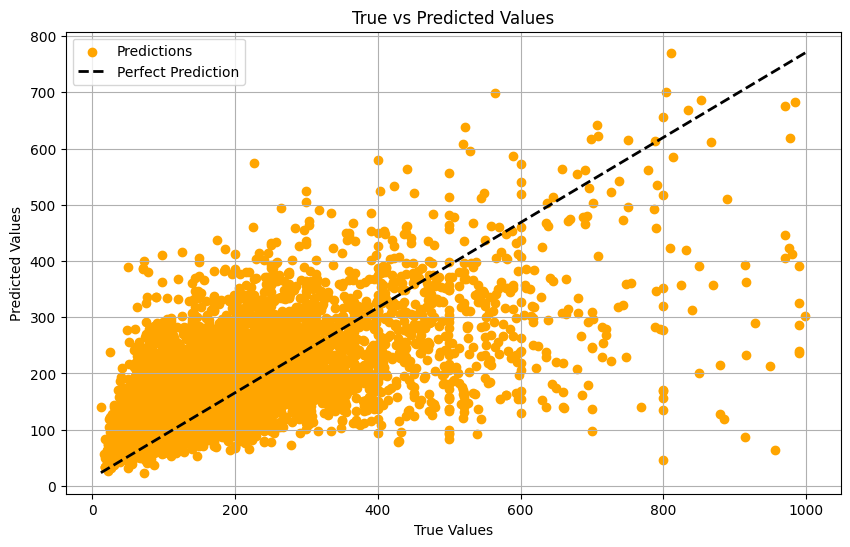

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred, color='orange', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [pred.min(), pred.max()], 'k--', lw=2, label='Perfect Prediction')
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

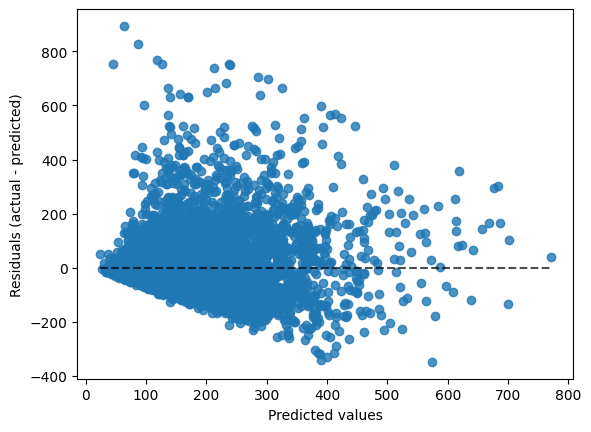

In [93]:

display = PredictionErrorDisplay(y_true=y_test, y_pred=pred)
display.plot()
plt.show()


In [94]:
import joblib
joblib.dump(best_pipe, 'pickle/KNNR.pkl', compress=True)

['pickle/KNNR.pkl']

In [95]:
best_pipe = joblib.load("pickle/KNNR.pkl")